In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
from torch.nn import functional as F
from torch.nn import Sequential, Tanh, Parameter
import mlflow as mlflow
%matplotlib inline

In [2]:
torch.manual_seed(42);

In [3]:
names = open("../datasets/llm/names.txt",mode="r",encoding="utf8").read().splitlines()
names[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [4]:
vocab = "".join(sorted(set(x for word in names+["."] for x in word))) # building vocab

In [5]:
len(vocab)

27

In [6]:
stoi = {k:v for v,k in enumerate(vocab)}
itos = {v:k for v,k in enumerate(vocab)}

In [7]:
torch.set_default_device("cpu")
def build_dataset(data, n_context):
    xs = []
    ys = []
    
    for x in data:
        context = [0]* n_context
        for ch in x + ".":
            # print(f"{context} {stoi[ch]}")
            ix = stoi[ch]
            xs.append(context)
            ys.append(ix)
            context = context[1:]+[ix]
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    print(xs.shape,ys.shape)
    return xs,ys

np.random.shuffle(names)

data_size =  len(names)

train_data = names[:int(data_size * .8)]
dev_data = names[int(data_size * .8):int(data_size * .9)]
test_data = names[int(data_size * .9):]

#hyperparameters
n_context = 8
e_dim = 10
h_dim = 200
n_consec = 2

Xtr,Ytr = build_dataset(train_data,n_context) 
Xdev,Ydev = build_dataset(dev_data,n_context)
Xtest,Ytest = build_dataset(test_data,n_context)

torch.Size([182337, 8]) torch.Size([182337])
torch.Size([22924, 8]) torch.Size([22924])
torch.Size([22885, 8]) torch.Size([22885])


In [16]:
class Linear(torch.nn.Module):
    def __init__(self,nin,nout,bias=True,weight=1):
        super().__init__()
        self.nin = nin
        self.nout = nout
        self.weights = Parameter(torch.randn(nin, nout) * weight)
        self.bias = Parameter(torch.randn(nout)) if bias else None

    
    def forward(self,x):
        self.out = x @ self.weights * self.nin**-0.5
        if self.bias != None:
            self.out = self.out + self.bias
        return self.out 

    # def parameters(self):
    #     self.parameters = [self.W1] + [self.b1] if self.b1!=None else [self.W1]
    #     return self.parameters 
        
class Flatten(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self,x):
        self.out = x.view(x.shape[0],-1)
        return self.out
        
class Embedding(torch.nn.Module):
    def __init__(self,vocab_size,edim):
        super().__init__()
        self.weights = Parameter(torch.randn(vocab_size, edim))

    def forward(self,x):
        self.out = self.weights[x]
        return self.out

    # def parameters(self):
    #     self.parameters = [self.embedding]
    #     return self.parameters

class BatchNorm1d(torch.nn.Module):
    def __init__(self,nout,alpha=0.001,eps=1e-05):
        super().__init__()
        self.nout = nout
        self.bgain = Parameter(torch.ones(1,nout))
        self.bbias = Parameter(torch.zeros(1,nout))
        self.bstdrunning = torch.ones(1,nout)
        self.bmeanrunning = torch.zeros(1,nout)
        self.alpha = alpha
        self.eps = eps
        
    def forward(self,x):
        if(self.training):
            dimn = len(x.shape) -1
            # print([*range(dimn)])
            bmeani = x.mean([*range(dimn)],keepdim=True)
            bstdi = x.std([*range(dimn)],keepdim = True)
            self.out = self.bgain*(x - bmeani)/ (bstdi + self.eps) + self.bbias
            with torch.no_grad():
                self.bmeanrunning = self.alpha * self.bmeanrunning + (1 - self.alpha)* bmeani
                self.bstdrunning = self.alpha * self.bstdrunning + (1 - self.alpha) * bstdi
        else:
            self.out = self.bgain*(x - self.bmeanrunning)/ (self.bstdrunning + self.eps) + self.bbias

        return self.out
   
    # def parameters(self):
    #     self.parameters = [self.bgain,self.bbias]
    #     return self.parameters

class FlattenConsecutive(torch.nn.Module):
    def __init__(self,n):
        super().__init__()
        self.n = n

    def forward(self,x):
        B,T,C = x.shape
        x=x.view(B,T//self.n,C * self.n)
        if x.shape[1] == 1:
           x =  x.squeeze(1)
        self.out = x
        return self.out

class Tanh1(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self,x):
        self.out = F.tanh(x)
        return self.out
        
@torch.no_grad()
def evaluate(X,Y,model):
    model.eval()
    out = model(X)
    loss = F.cross_entropy(out,Y)
    return out,loss

@torch.no_grad()
def generate(n_words,model):
    model.eval()
    for i in range(10):
        #forward pass
        out = []
        context = [0] * 8
        while True:
            logits= model(torch.tensor(context).view(1,-1))
            p = F.softmax(logits,dim=1)
            ix = torch.multinomial(p,num_samples = 1, replacement = True)
            context = context[1:] + [ix.item()]
            if ix.item() == 0:
                break
            out.append(itos[ix.item()])
        print("".join(out))


In [17]:
Model =  Sequential(
    Embedding(len(vocab),e_dim),
    FlattenConsecutive(n_consec),Linear(n_consec*e_dim,h_dim,False),BatchNorm1d(h_dim),Tanh1(),
    FlattenConsecutive(n_consec),Linear(n_consec*h_dim,h_dim,False),BatchNorm1d(h_dim),Tanh1(),
    FlattenConsecutive(n_consec),Linear(n_consec*h_dim,h_dim,False),BatchNorm1d(h_dim),Tanh1(),
    Linear(h_dim,len(vocab),weight=0.1)
    
)

In [18]:
for x in Model.parameters():
    print(x.shape)

torch.Size([27, 10])
torch.Size([20, 200])
torch.Size([1, 200])
torch.Size([1, 200])
torch.Size([400, 200])
torch.Size([1, 200])
torch.Size([1, 200])
torch.Size([400, 200])
torch.Size([1, 200])
torch.Size([1, 200])
torch.Size([200, 27])
torch.Size([27])


In [ ]:
batch_size = 32
lrsloss = []
lossi = []

for i in range(200000):
    #forward pass
    # print(i)
    lr = 0.01 if i <100000 else 0.001
    Model.train()
    # optimizer = torch.optim.SGD(Model.parameters(), lr=lr)
    ix = torch.randint(0,high = Xtr.shape[0],size=(batch_size,))
    out= Model.forward(Xtr[ix])
    # print(out.shape)
    loss = F.cross_entropy(out,Ytr[ix])
    lossi.append(loss.log10().item())
    if i % 10000 == 0:
        print(F"loss at {i}/200000 {loss.item():.4f}")
    #backpass
    for p in Model.parameters():
        p.grad = None
    loss.backward(retain_graph=True)
    for p in Model.parameters():
        p.data += -lr*p.grad

    # if i == 1:
    #     break
        

print(F" Final loss: {loss.item():.4f}")

loss at 0/200000 3.5366
loss at 10000/200000 2.1999
loss at 20000/200000 2.4702
loss at 30000/200000 2.8373
loss at 40000/200000 2.3525
loss at 50000/200000 2.6504
loss at 60000/200000 2.3649
loss at 70000/200000 2.3244
loss at 80000/200000 2.5135
loss at 90000/200000 2.4074
loss at 100000/200000 2.3695
loss at 110000/200000 2.7043
loss at 120000/200000 2.4481
loss at 130000/200000 2.5822
loss at 140000/200000 2.3335
loss at 150000/200000 2.5060
loss at 160000/200000 2.2840
loss at 170000/200000 2.3431
loss at 180000/200000 2.2326


In [ ]:
evaluate(Xdev,Ydev,Model)

(tensor([[-0.5600,  1.6649, -0.5296,  ..., -1.5650,  0.1482, -0.7073],
         [-0.0832,  2.1408, -0.7689,  ..., -1.4366,  0.4995, -0.8011],
         [ 0.0620,  1.9524, -0.7692,  ..., -1.4500,  0.5732, -0.9283],
         ...,
         [ 3.1483,  1.7990, -0.9618,  ..., -1.4096,  0.5512, -0.8943],
         [ 3.6924,  1.6617, -1.0228,  ..., -1.3401,  0.4162, -0.9324],
         [ 3.6162,  1.6111, -0.9454,  ..., -1.3459,  0.4995, -0.9635]]),
 tensor(2.6075))

In [ ]:
evaluate(Xtest,Ytest,Model)

(tensor([[-0.5600,  1.6649, -0.5296,  ..., -1.5650,  0.1482, -0.7073],
         [-0.0851,  2.1617, -0.7433,  ..., -1.4193,  0.4912, -0.8513],
         [ 0.1510,  1.8724, -0.7847,  ..., -1.4125,  0.7247, -0.9878],
         ...,
         [ 3.3344,  1.8218, -0.9067,  ..., -1.3436,  0.4718, -0.9154],
         [ 3.6931,  1.5361, -1.0030,  ..., -1.3497,  0.3937, -0.9819],
         [ 3.8898,  1.6649, -0.8943,  ..., -1.4155,  0.4093, -0.9234]]),
 tensor(2.6028))

In [ ]:
generate(10,Model)

jao
r
ejnele
aenceagda
ehlrihmy
emkalnwn
a
aa
aayalm
ulhlcoajnoj


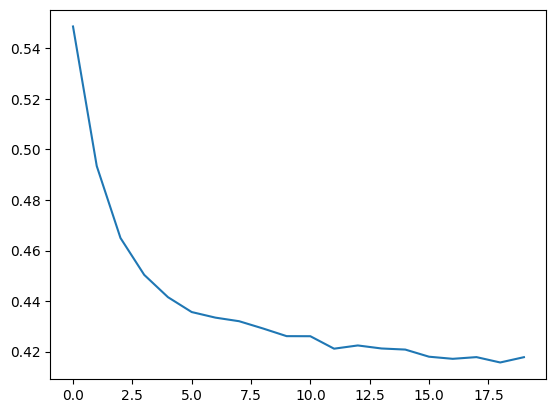

In [ ]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1));